In [365]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import math
import matplotlib.pyplot as plt
import pandas as pd
Device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [337]:
x = torch.randn((10, 32, 512))


In [338]:
x.argmax(2)

tensor([[305, 478,  65, 325, 371, 214,  84, 105, 470,  51, 176, 358,  29, 339,
         444,  60, 421, 390, 289, 187,  79, 256, 325, 222,   1, 128,  23,  59,
         325,  48, 228, 312],
        [460, 107, 148, 404, 483, 326, 504, 188, 225, 458, 187,   9, 240, 392,
         272, 102,  39, 181, 169, 445, 190, 362, 109, 477, 467, 299, 131, 280,
         331,  76, 286, 267],
        [439, 228, 273, 335, 275, 488, 270, 304, 454,  63, 316, 321,  68, 395,
         487, 402, 369, 396, 304, 377, 300, 292,  64, 161,  47,  63,  71, 130,
         190, 382, 260, 477],
        [428, 343, 317, 374, 258, 455, 250, 276, 453,  75, 280, 342, 395, 316,
         207,  33,  61, 194, 418, 446, 111, 258, 175,  34, 115, 241, 259, 127,
         363, 118, 489,  33],
        [340, 193, 390, 251, 264, 204,  29, 402, 283, 393,  42, 290, 176, 164,
         508, 368, 360, 262, 504, 372, 450,  30, 335, 233, 138, 332, 149, 325,
          40, 334, 160, 491],
        [477, 179,  67, 188, 453, 395, 293, 277,  62, 321, 4

In [339]:
x[0][0].argmax()

tensor(305)

NameError: name '_generate_square_subsequent_mask' is not defined

In [250]:
data = pd.read_csv("sw1_base_info_daily.csv", sep="\t", index_col= 0).iloc[:,:5]
code = pd.read_csv("swcode.csv", header= None)
finaldata = []
for i in range(len(code[0])):
    finaldata.append(data[data["code"] == code[0][i]]["close"].pct_change()[1:])
data = torch.Tensor(finaldata ).T

In [286]:
class LanguageModelDataLoader(DataLoader):
    """
        TODO: Define data loader logic here
    """
    def __init__(self, dataset, batch_size, seq_len):
        self.data = dataset
        self.batch_size = batch_size 
        self.baselen = 15
        self. seq_len = seq_len


    def __iter__(self):
        # numiter = len(self.dataset) / self.batch_size
        # for (i in range(numiter)):
        left = len(self.data) % (self.seq_len * self.batch_size)
        self.data = self.data[left:]
        # print(self.data.shape)
        i = 0
        while (i < len(self.data)):
            # bptt = self.baselen if np.random.random() < 0.95 else self.baselen / 2.
            # seq_len = max(5, int(np.random.normal(bptt, 5)))
            # print(self.data[i : (i + self.seq_len * self.batch_size)].shape)
            res = self.data[i : (i + self.seq_len * self.batch_size)].reshape(self.batch_size, self.seq_len, self.data.shape[1])
            i = i + self.seq_len * self.batch_size
            encode = res[:, :10,:].permute(1, 0, 2).contiguous() 
            decode = res[:, 9:20,:].permute(1, 0, 2).contiguous() 
            target = res[:,10:21,:].permute(1, 0, 2).contiguous() 
            # print(target.shape)
            yield (encode, decode, target)

        

In [287]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=20):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        #pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

In [288]:
model = PositionalEncoding(20)

In [351]:
class Transformer(nn.Module):
    def __init__(self, indimen, feature_size, outdimen, nlayer, head, mask = None):
        super(Transformer, self).__init__()
        self.inputlayer = nn.Linear(indimen, feature_size)
        self.pos_encoder = PositionalEncoding(feature_size)
        self.transformerencoder = nn.TransformerEncoderLayer(d_model=feature_size, nhead=head, dropout=0.1)
        self.encoder = nn.TransformerEncoder(self.transformerencoder, num_layers = nlayer)

        self.transformerdecoder = nn.TransformerDecoderLayer(d_model = feature_size, nhead = head, dropout= 0.1)

        self.decoderlayer = nn.TransformerDecoder(self.transformerdecoder, 2)
        self.outlayer = nn.Linear(feature_size, outdimen)
        self.mask = mask
    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask
    def forward(self, encoder_data, decoder_data):
        if (self.mask == None):
            self.mask = self._generate_square_subsequent_mask(len(decoder_data))
        # print(self.mask.unsqueeze(0))
        res = self.inputlayer(encoder_data)
        res = self.pos_encoder(res)
        res = self.encoder(res)
        # print(res.shape)
        # print(decoder_data.shape)
        res = self.decoderlayer(decoder_data, res, tgt_mask = self.mask)
        res = self.outlayer(res)
        return res.permute(1, 0, 2).contiguous()

In [361]:
class TransformerTraining:
    def __init__(self, model, loader, loadertest, max_epochs = 1):
        super(TransformerTraining, self).__init__()
        self.model = model.to(Device)
        self.loader = loader
        self.testloader = loadertest
        self.max_epochs = max_epochs
        self.tran_loss = []
        self.val_loss = []
        self.predict = []
        self.predict_test = []
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr = 0.0001, weight_decay= 1e-6)
        self.lossfun = nn.CrossEntropyLoss().to(Device)
        # self.scheduler = torch.optim.lr_scheduler(self.optimizer)
        self.epochs = 0
    
    def trainfn(self):
        self.model.train()
        epoch_loss = 0
        for id, (endata, dedata, target) in enumerate(self.loader):
            outputs = self.model(endata, dedata)
            loss = self.lossfun(outputs.reshape(-1, outputs.size(2)), target.argmax(2).reshape(-1))
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            epoch_loss += loss.item()
        epoch_loss /= id + 1
        self.epochs = self.epochs + 1
        print('[TRAIN]  Epoch [%d/%d]   Loss: %.4f'
                      % (self.epochs + 1, self.max_epochs, epoch_loss))
        self.tran_loss.append(epoch_loss)
    
    def evalfn(self):
        self.model.eval()
        epoch_loss = 0
        for id, (endata, dedata, target) in enumerate(self.testloader):
            outputs = self.model(endata, dedata)
            self.predict.append(outputs)
            self.predict_test.append(target)
            loss = self.lossfun(outputs.reshape(-1, outputs.size(2)), target.argmax(2).reshape(-1))
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            epoch_loss += loss.item()
        epoch_loss /= id + 1
        print('[TRAIN]  Epoch [%d/%d]   Loss: %.4f'
                      % (self.epochs + 1, self.max_epochs, epoch_loss))
        self.val_loss.append(epoch_loss)
        return epoch_loss

In [374]:
factornumber = 28
indimen =  28
outdimen = factornumber
num_layers = 2
NUM_EPOCHS = 20
BATCH_SIZE = 2
slide = int (data.shape[0] * 0.8)
loader = data[:slide ]
valloader = data[slide :]

model = Transformer(factornumber, indimen, outdimen, 4, num_layers)
loader = LanguageModelDataLoader(dataset=data[:slide ], batch_size=BATCH_SIZE, seq_len = 21)
valloader = LanguageModelDataLoader(dataset=data[slide :], batch_size=1, seq_len = 21)
trainer = TransformerTraining(model=model, loader=loader, loadertest = valloader, max_epochs=NUM_EPOCHS)


best_nll = 1e30 
for epoch in range(NUM_EPOCHS):
    print(epoch)
    trainer.trainfn()
    nll = trainer.evalfn()
    if nll < best_nll:
        best_nll = nll
    print("Saving model, predictions and generated output for epoch "+str(epoch)+" with NLL: "+ str(best_nll))

0
[TRAIN]  Epoch [2/20]   Loss: 3.2175
[TRAIN]  Epoch [2/20]   Loss: 3.2413
Saving model, predictions and generated output for epoch 0 with NLL: 3.241253926203801
1
[TRAIN]  Epoch [3/20]   Loss: 3.1233
[TRAIN]  Epoch [3/20]   Loss: 3.1788
Saving model, predictions and generated output for epoch 1 with NLL: 3.1788347776119528
2
[TRAIN]  Epoch [4/20]   Loss: 3.1205
[TRAIN]  Epoch [4/20]   Loss: 3.1483
Saving model, predictions and generated output for epoch 2 with NLL: 3.148295971063467
3
[TRAIN]  Epoch [5/20]   Loss: 3.1212
[TRAIN]  Epoch [5/20]   Loss: 3.1348
Saving model, predictions and generated output for epoch 3 with NLL: 3.13478684425354
4
[TRAIN]  Epoch [6/20]   Loss: 3.1222
[TRAIN]  Epoch [6/20]   Loss: 3.1285
Saving model, predictions and generated output for epoch 4 with NLL: 3.1284934282302856
5
[TRAIN]  Epoch [7/20]   Loss: 3.1149
[TRAIN]  Epoch [7/20]   Loss: 3.1209
Saving model, predictions and generated output for epoch 5 with NLL: 3.1208860874176025
6
[TRAIN]  Epoch [8/

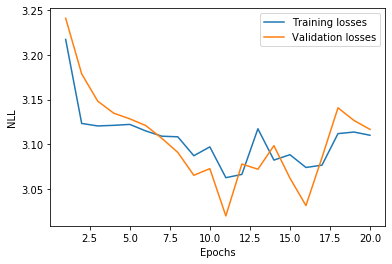

In [375]:
plt.figure()
plt.plot(range(1, trainer.epochs + 1), trainer.tran_loss, label='Training losses')
plt.plot(range(1, trainer.epochs + 1), trainer.val_loss, label='Validation losses')
plt.xlabel('Epochs')
plt.ylabel('NLL')
plt.legend()
plt.show()


In [52]:
import pandas as pd
import numpy as np

In [85]:
data = pd.read_csv("sw1_base_info_daily.csv", sep="\t", index_col= 0).iloc[:,:5]
code = pd.read_csv("swcode.csv", header= None)

In [86]:
d = data.groupby(by = "day").count().groupby(by = "code").count()

In [87]:
a = data.groupby(by = "day").count()

In [218]:
# data[a["code"] == 266].iloc[:266]
# data

In [90]:
# np.loadtxt("swcode.csv", delimiter= ".")
code = pd.read_csv("swcode.csv", header= None)

In [ ]:
import matplotlib.pyplot as plt

In [81]:
plt.plot(d.index, d["code"])

In [232]:
data = pd.read_csv("sw1_base_info_daily.csv", sep="\t", index_col= 0).iloc[:,:5]
code = pd.read_csv("swcode.csv", header= None)
finaldata = []
for i in range(len(code[0])):
    finaldata.append(data[data["code"] == code[0][i]]["close"].pct_change()[1:])
data = torch.Tensor(finaldata ).T

In [233]:
data = torch.Tensor(finaldata ).T

In [234]:
data[2][0]

tensor(0.0268)

In [195]:

data.T.shape

torch.Size([2820, 28])

In [228]:
loader = LanguageModelDataLoader(data.T, 2, 21)

In [231]:
for g in loader:
    print(g[0][0,:,0])
    print(g[1][0,:,0])
    print(g[2][0,:,0])
    print("++++++")
    break

tensor([ 0.0335,  0.0121,  0.0113, -0.0039,  0.0077, -0.0019,  0.0045,  0.0021,
         0.0466,  0.0160])
tensor([ 0.0160,  0.0232,  0.0118,  0.0306,  0.0194,  0.0291, -0.0178,  0.0018,
         0.0376,  0.0279, -0.0398])
tensor([ 0.0232,  0.0118,  0.0306,  0.0194,  0.0291, -0.0178,  0.0018,  0.0376,
         0.0279, -0.0398, -0.0283])
++++++


In [166]:
b = iter(loader)

In [167]:
for i in b:
    print(i)

In [176]:
for i, (inputs, g, targets) in enumerate(loader):
    print(i)